# Financial Analysis of U.S. Healthcare Companies Using Python and SQL

## Project Overview

This notebook provides a structured walkthrough of a Python and SQL-based pipeline for analyzing the financial performance of four major U.S. healthcare companies: Johnson & Johnson (JNJ), Pfizer (PFE), United Healthcare (UNH), and Medtronic (MDT). The goal is to showcase how data can be retrieved from a public API, stored, queried, and visualized to reveal meaningful financial insights.

## Notebook Purpose

Rather than duplicating all code, this notebook is designed to give readers a clear **overview of the workflow**. It selectively presents key pieces of code and runs the rest via script execution for clarity and conciseness.

## End-to-End Workflow
1. Fetch financial data using the Alpha Vantage API (or fall back to local data).
2. Store the data in a structured SQLite database.
3. Run a series of SQL queries to extract insights on valuation, profitability, earnings surprises, and volatility.
4. Visualize the results using Python.

## 1. Fetch Data

The pipeline retrieves key financial data using the Alpha Vantage API, including balance sheets, income statements, stock prices, earnings reports, and company overviews. In this section, the process for fetching balance sheet data is shown in full to illustrate how the API is used. The remaining data-fetching scripts follow the same structure and will be executed directly using script calls for brevity.

### 1.1 Fetching Balance Sheet Data

#### Import Libraries

In [1]:
from pathlib import Path
from dotenv import load_dotenv
from datetime import datetime
import requests
import pandas as pd
import os
import sys
import subprocess
import sqlite3
from IPython.display import Image, display

#### Set Project Directory Dynamically

In [2]:
# Set BASE_DIR dynamically
if "ipykernel" in sys.modules:  # Checks if running in Jupyter Notebook
    from IPython import get_ipython
    notebook_path = Path(get_ipython().run_line_magic('pwd', '')).resolve()

    if notebook_path.name == "notebooks":
        BASE_DIR = notebook_path.parent
    else:
        BASE_DIR = notebook_path
else:
    # Fallback (if running in Spyder)
    BASE_DIR = Path().resolve()

output_path = BASE_DIR / "data" / "balance_sheets.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)

#### Helper Function

In [3]:
# Helper function where integer values are reported as 'None'
def safe_int(val):
    try:
        if val in [None, 'None', '']:
            return 0
        return int(float(val))
    except (ValueError, TypeError):
        return 0

#### Load API Key and Fetch Balance Sheets

In [4]:
# Load API key from environment variable
load_dotenv(BASE_DIR / ".env")
API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")

# Stop execution if no API key is found
if not API_KEY or API_KEY == "your_actual_api_key_here":
    print("No valid API key found. Existing balance sheet data will be used instead.")
    sys.exit()
    
# Fetch data if API key exists
SYMBOLS = ["JNJ", "PFE", "UNH", "MDT"]
balance_sheets = []

numeric_fields = [
    "totalAssets", "totalCurrentAssets", "cashAndCashEquivalentsAtCarryingValue", "cashAndShortTermInvestments", 
    "inventory", "currentNetReceivables", "totalNonCurrentAssets", "propertyPlantEquipment", 
    "accumulatedDepreciationAmortizationPPE", "intangibleAssets", "intangibleAssetsExcludingGoodwill", 
    "goodwill", "investments", "longTermInvestments", "shortTermInvestments", "otherCurrentAssets", 
    "otherNonCurrentAssets", "totalLiabilities", "totalCurrentLiabilities", "currentAccountsPayable", "deferredRevenue", 
    "currentDebt", "shortTermDebt", "totalNonCurrentLiabilities", "capitalLeaseObligations", "longTermDebt", 
    "currentLongTermDebt", "longTermDebtNoncurrent", "shortLongTermDebtTotal", "otherCurrentLiabilities", 
    "otherNonCurrentLiabilities", "totalShareholderEquity", "treasuryStock", "retainedEarnings", "commonStock", 
    "commonStockSharesOutstanding"
    ]

for SYMBOL in SYMBOLS:
    URL = f"https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={SYMBOL}&apikey={API_KEY}"
    print(f"Fetching balance sheets for {SYMBOL}...")
    try:
        response = requests.get(URL, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        # Check if response contains valid data
        if "annualReports" not in data:
            print(f"API request failed for {SYMBOL}. Existing balance sheet data will be used instead.")
            sys.exit()
            
        print(f"Balance sheets fetched successfully for {SYMBOL}!")
        
        # Extract balance sheets
        reports = ["annualReports", "quarterlyReports"]
        for report in reports:
            for report_entry in data[report]:
                symbol = SYMBOL
                report_type = "annual" if report == "annualReports" else "quarterly"
                try:
                    fiscal_date = datetime.strptime(report_entry.get("fiscalDateEnding"), "%Y-%m-%d")
                except (TypeError, ValueError):
                    fiscal_date = None
                
                reported_currency = report_entry.get("reportedCurrency")
                                
                numeric_values = [safe_int(report_entry.get(field)) for field in numeric_fields]
                
                balance_sheets.append([
                    symbol,
                    report_type,
                    fiscal_date,
                    reported_currency,
                    *numeric_values  # Unpack all numeric values in order
                    ])

    except (requests.exceptions.RequestException, ValueError) as e:
        print(f"API request error for {SYMBOL}: {e}. Existing balance sheet data will be used instead.")
        sys.exit()

balance_sheets_df = pd.DataFrame(balance_sheets, columns=[
    "symbol", 
    "report_type", 
    "fiscal_date", 
    "reported_currency",
    *numeric_fields
    ])        
        
# Save DataFrames to CSV
balance_sheets_df.to_csv(output_path, index=False)

Fetching balance sheets for JNJ...
Balance sheets fetched successfully for JNJ!
Fetching balance sheets for PFE...
Balance sheets fetched successfully for PFE!
Fetching balance sheets for UNH...
Balance sheets fetched successfully for UNH!
Fetching balance sheets for MDT...
Balance sheets fetched successfully for MDT!


#### 1.2 Run Additional Fetch Scripts

The following scripts will run in sequence as subprocesses:  
- `fetch_company_overviews.py`  
- `fetch_earnings.py`  
- `fetch_income_statements.py`  
- `fetch_stock_prices.py`  
Each script fetches data from the Alpha Vantage API and stores it in the `data/` directory.

In [5]:
# Define the scripts directory
SCRIPTS_DIR = BASE_DIR / "scripts"

script_files = [
    "fetch_company_overviews.py",
    "fetch_earnings.py",
    "fetch_income_statements.py",
    "fetch_stock_prices.py"
]

for script_file in script_files:
    script_path = SCRIPTS_DIR / script_file
    print(f"\nRunning {script_file}")
    
    try:
        subprocess.run(["python", str(script_path)], check=True)
        print("Done!")
    except subprocess.CalledProcessError as e:
        print(f"Script {script_file} failed with error code: {e.returncode}")


Running fetch_company_overviews.py
Done!

Running fetch_earnings.py
Done!

Running fetch_income_statements.py
Done!

Running fetch_stock_prices.py
Done!


## 2. Load CSV Files into SQL Database
This section initializes a new SQLite database (MarketData.db) and writes each CSV file to its corresponding table using pandas.to_sql(). If an existing database is found, it is deleted to ensure a clean state and prevent schema or data conflicts.

In [6]:
# Manage paths
DB_PATH = BASE_DIR / "database" / "MarketData.db"
DB_PATH.parent.mkdir(parents=True, exist_ok=True)

csv_table_pairs = [
    ("stock_prices.csv", "stock_prices"),
    ("annual_earnings.csv", "annual_earnings"),
    ("quarterly_earnings.csv", "quarterly_earnings"),
    ("income_statements.csv", "income_statements"),
    ("balance_sheets.csv", "balance_sheets"),
    ("company_overviews.csv", "company_overviews")
]

# Safely delete the database file if it exists
if DB_PATH.exists():
    DB_PATH.unlink()

# Create and populate new SQLite database
with sqlite3.connect(DB_PATH) as conn:
    for filename, table_name in csv_table_pairs:
        csv_path = BASE_DIR / "data" / filename
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            df.to_sql(table_name, conn, if_exists="replace", index=False)
            print(f"Loaded {table_name} from {filename}")
        else:
            print(f"File not found: {csv_path}")

Loaded stock_prices from stock_prices.csv
Loaded annual_earnings from annual_earnings.csv
Loaded quarterly_earnings from quarterly_earnings.csv
Loaded income_statements from income_statements.csv
Loaded balance_sheets from balance_sheets.csv
Loaded company_overviews from company_overviews.csv


## 3. Run SQL Queries and Export Results

This section loads and executes each `.sql` query file from the `queries/` folder using the `MarketData.db` SQLite database.

Each SQL file begins with a comment describing what the query does, which is displayed alongside the SQL code in the notebook output.

The queries are designed to extract meaningful financial and stock performance insights, such as:
- Valuation multiples (e.g., P/E ratios, market cap comparisons)
- Annual profitability ratios
- Earnings surprises and related price reactions
- Post-earnings drift behavior
- Stock price volatility over recent months
- Monthly counts of strong price gains

For each query, the script prints the file name, displays the full SQL code (including the explanatory comment), shows a preview of the resulting data, and saves the results as `.csv` files in the `results/` folder.

If the database or queries folder is missing, an error will be raised. The results folder is created automatically if it does not already exist.

In [7]:
# Set paths
DB_PATH = BASE_DIR / "database" / "MarketData.db"
QUERIES_DIR = BASE_DIR / "queries"
RESULTS_DIR = BASE_DIR / "results"

# Check required files and folders
if not DB_PATH.exists():
    raise FileNotFoundError(f"Database file not found at: {DB_PATH}")

if not QUERIES_DIR.exists():
    raise FileNotFoundError(f"Queries folder not found at: {QUERIES_DIR}")

if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir(parents=True)

def run_query_with_preview(query_file: str):
    query_path = QUERIES_DIR / query_file

    # Load the SQL query
    with open(query_path, 'r') as file:
        sql = file.read()

    # Print description and SQL code
    print("="*80)
    print(f"QUERY FILE: {query_file}")
    print("="*80, "\n")
    print(sql)
    print("-"*80)
    
    # Connect to database and run query
    with sqlite3.connect(DB_PATH) as conn:
        try:
            df = pd.read_sql_query(sql, conn)
        except Exception as e:
            print(f"Error running {query_file}: {e}")
            raise RuntimeError(f"Error running {query_file}: {e}")

    # Save result
    result_file = query_file.replace(".sql", ".csv")
    result_path = RESULTS_DIR / result_file
    df.to_csv(result_path, index=False)

    # Output preview
    print("\nResult preview:\n")
    print(df.head(), "\n\n")
    
# Create list if all sql queries in query folder 
query_files = [file.name for file in QUERIES_DIR.glob("*.sql")]
    
# Execute all sql queries
for query_file in query_files:
    run_query_with_preview(query_file)

QUERY FILE: earnings_surprise_vs_price_reaction.sql

-- Computes earnings surprise and the corresponding 5-day stock return for the 
-- last 20 quarters. Surprise is calculated as the percent difference between
-- reported and estimated EPS. Stock return reflects the percentage change in 
-- closing price from the report date to five trading days later. 

WITH stock_prices_rows AS (
    SELECT
	    symbol,
		date,
		close,
		ROW_NUMBER() OVER (PARTITION BY symbol ORDER BY date) AS stock_rn
	FROM
	    stock_prices
),
earnings_rows AS (
    SELECT
	    e.symbol,
		e.fiscal_quarter,
		e.reported_date,
		e.surprise_pct,
		s.stock_rn AS earnings_rn 
	FROM
	    quarterly_earnings AS e
	JOIN
	    stock_prices_rows AS s ON e.symbol=s.symbol AND e.reported_date=s.date		
)
SELECT
    e.symbol,
    c.Name AS name,
	e.fiscal_quarter,
	e.reported_date,
	ROUND(e.surprise_pct, 2) AS surprise_pct,
	s0.close AS day_0_price,
	s5.close AS day_5_price,
	ROUND(100*(s5.close-s0.close)/s0.close,2) AS price_c

## 4. Visualize Results and Display Figures

This section runs a series of standalone Python scripts that generate visualizations based on previously saved query results.  
Each script reads a specific `.csv` file from the `results/` directory, creates a figure, and saves it to the `figures/` folder.

After each script is executed as a subprocess, the notebook attempts to locate and display the corresponding `.png` file.  
This allows the visualizations to be run externally (for modularity) while still being displayed inline in the notebook.

If a script fails to run or a figure file is not found, a message will be printed to indicate the issue.



Running visualize_earnings_surprise_vs_price.py...
Script finished!


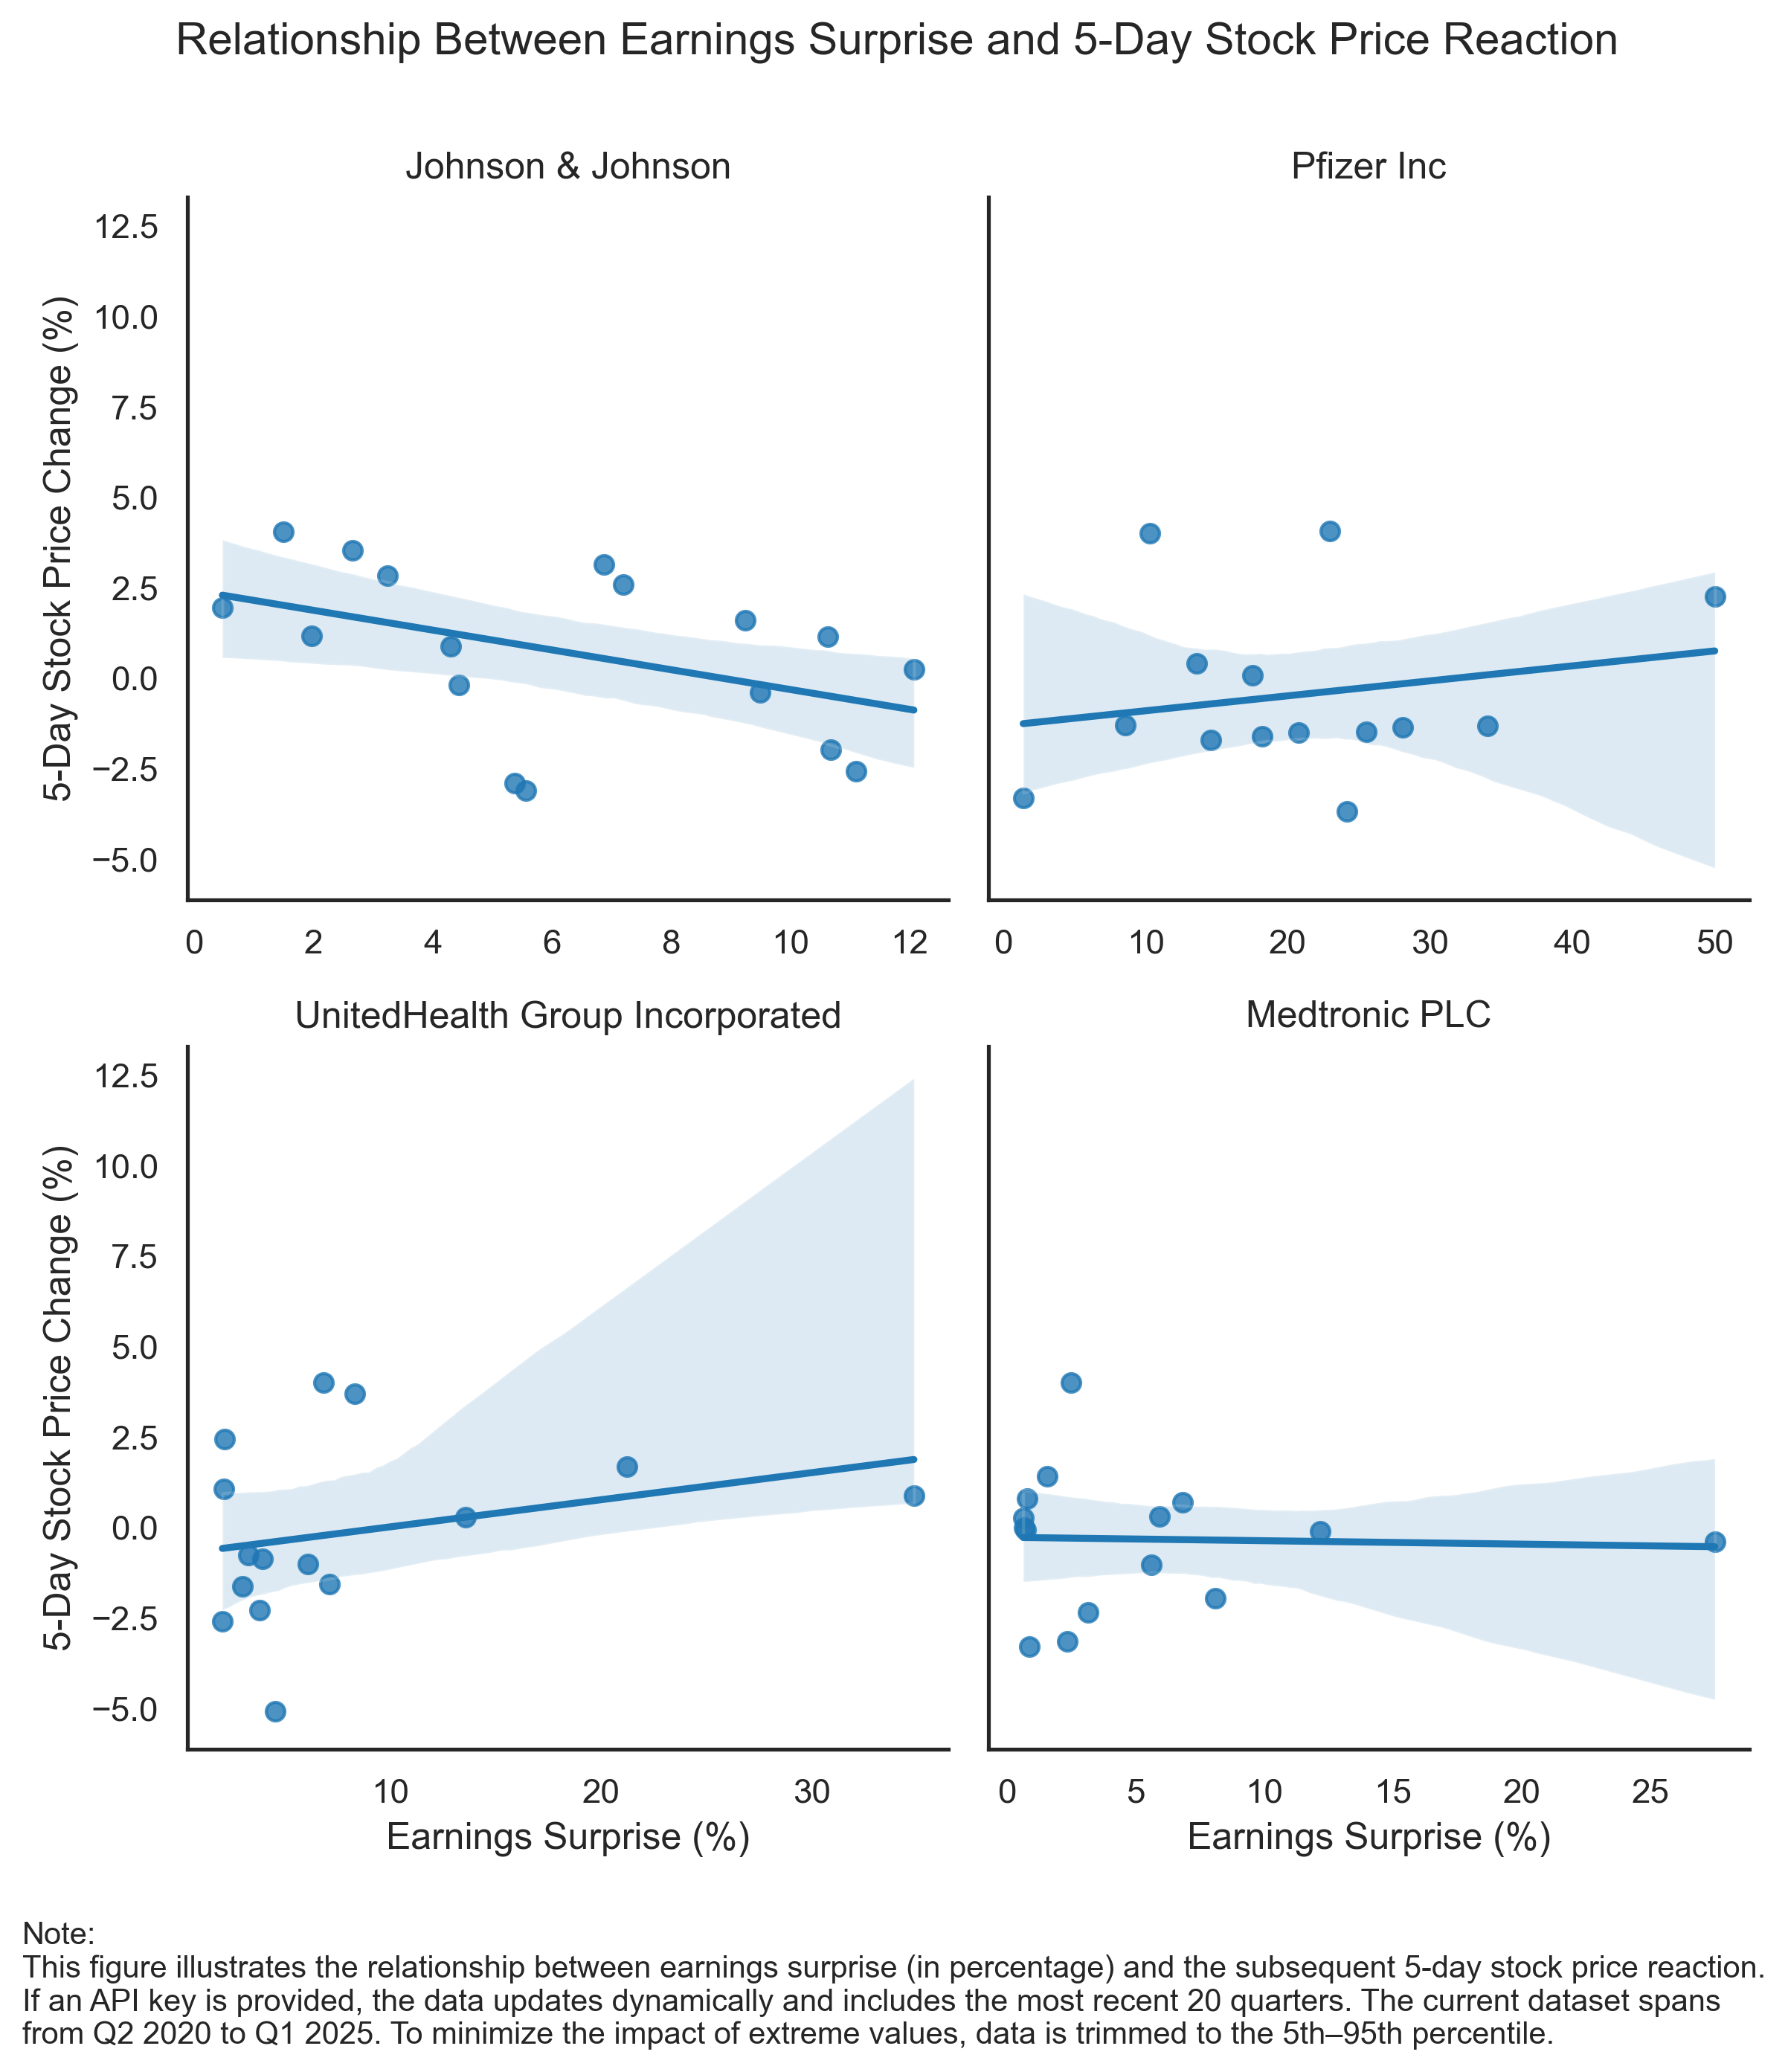


Running visualize_monthly_net_2pct_gain_counts.py...
Script finished!


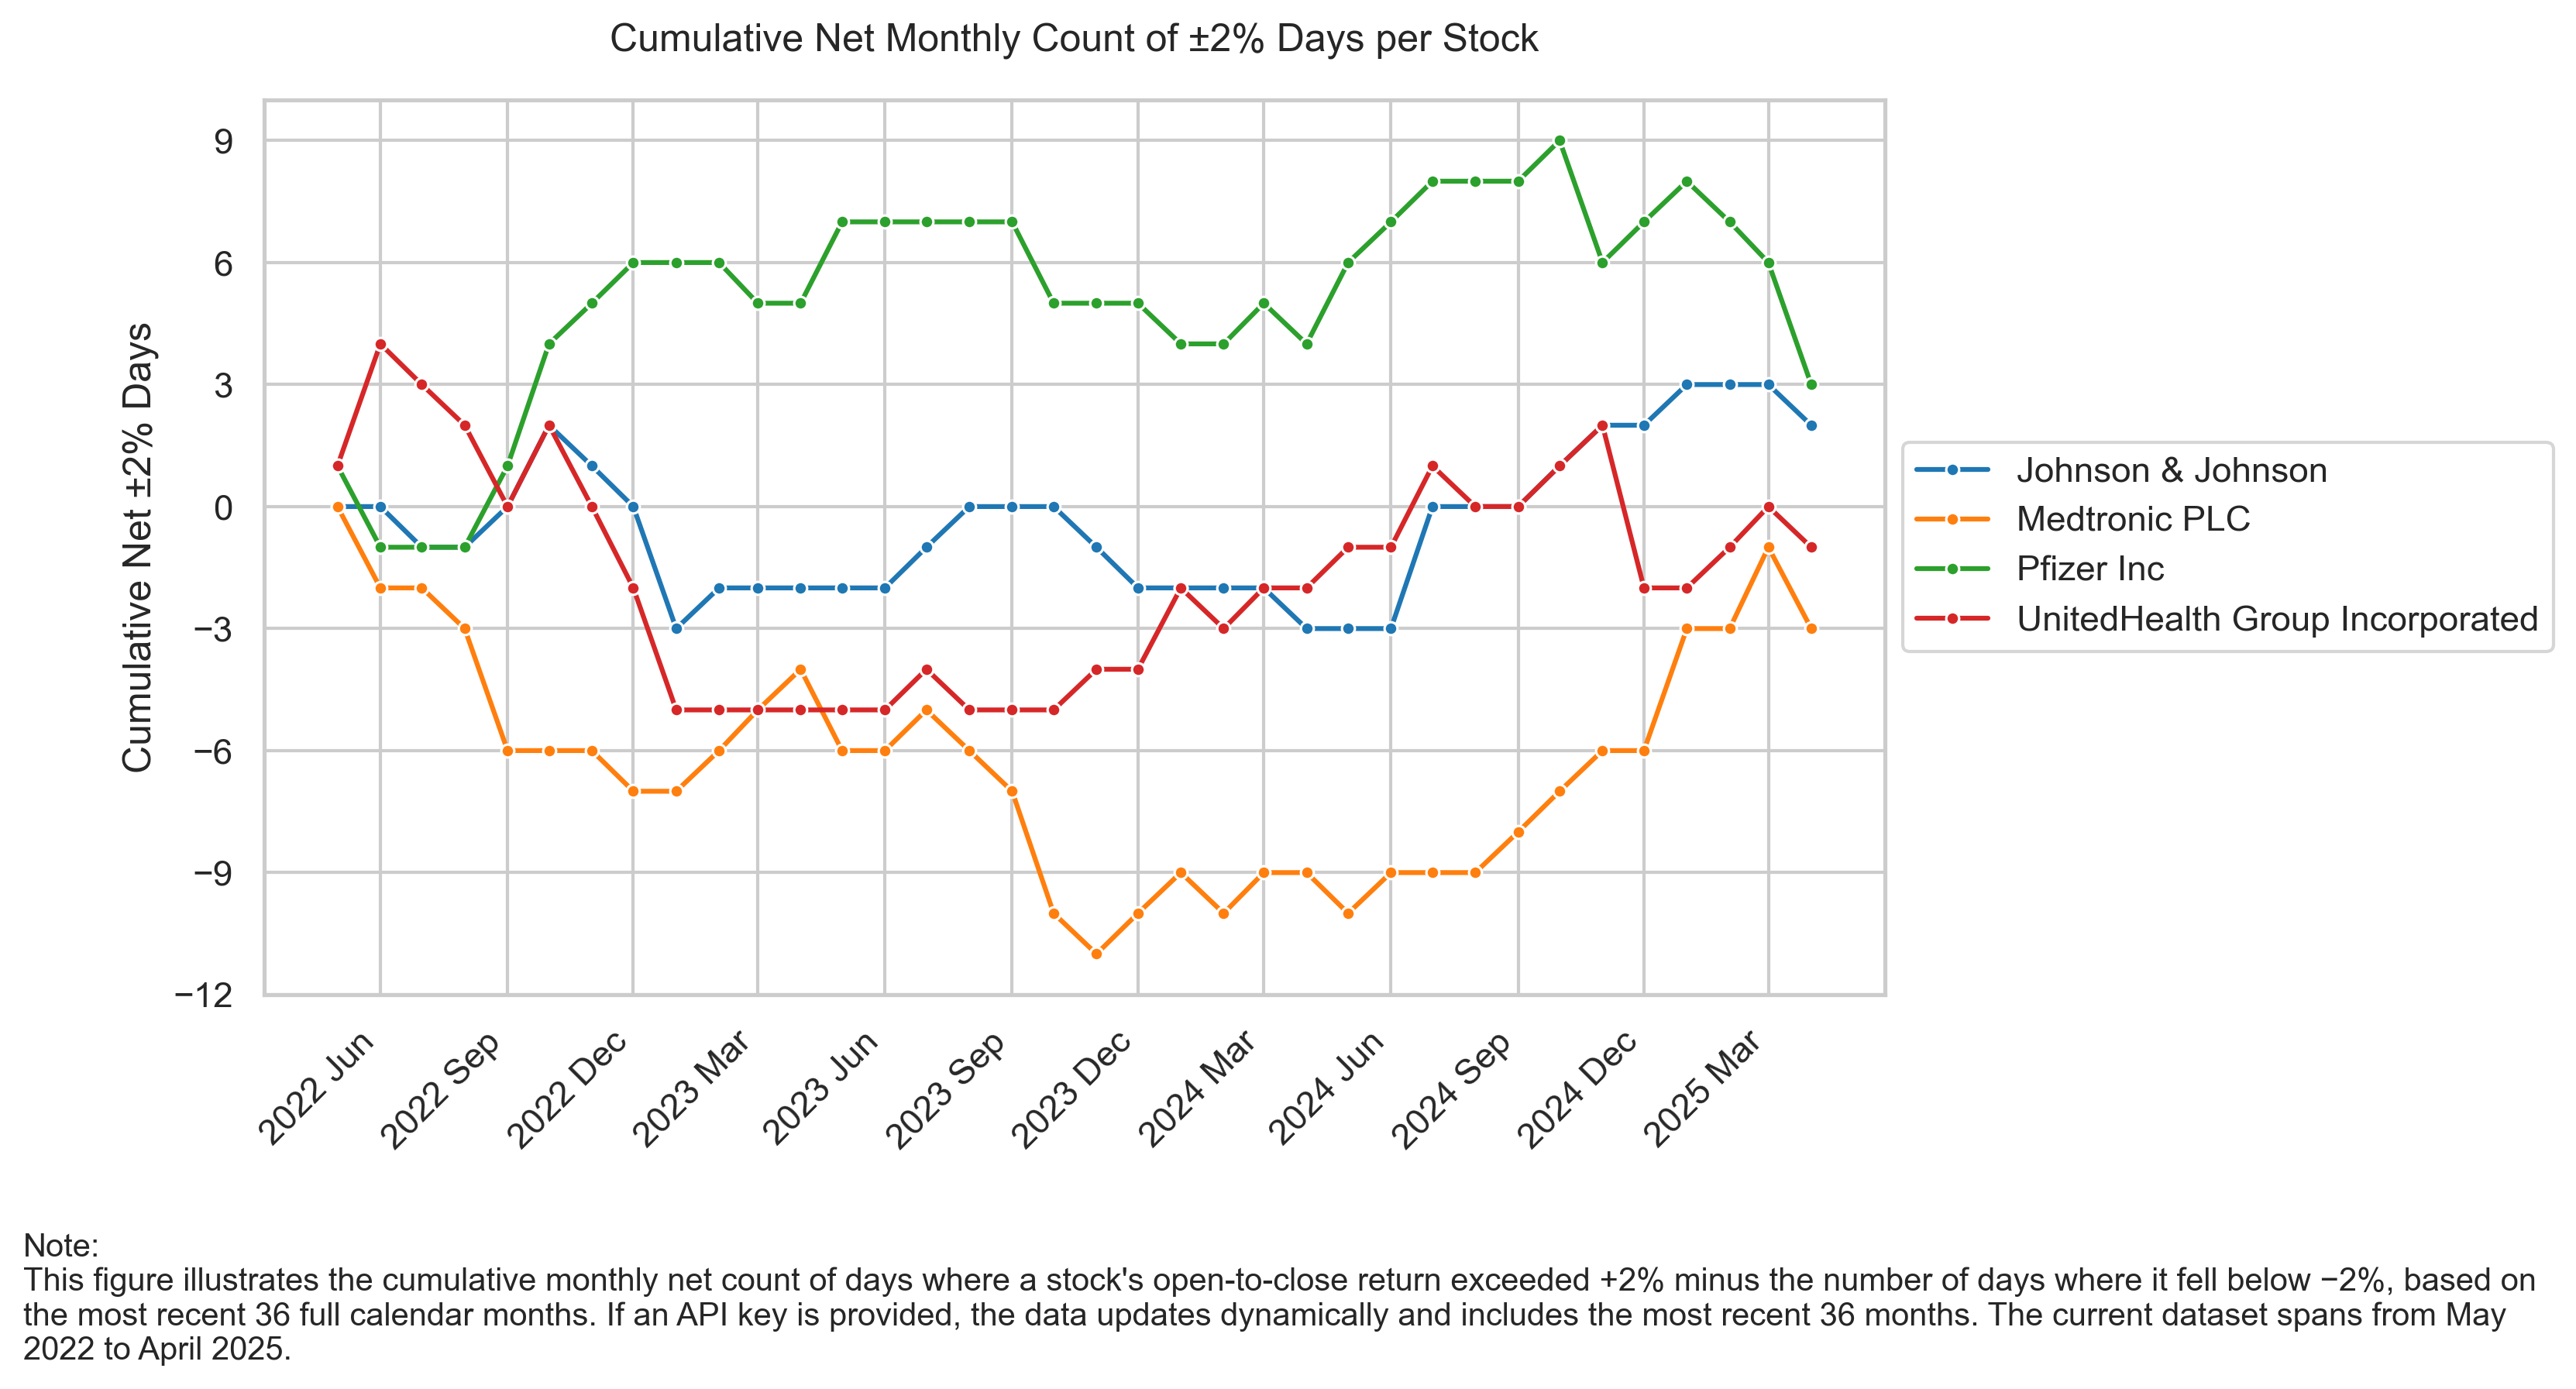


Running visualize_post_earnings_drift.py...
Script finished!


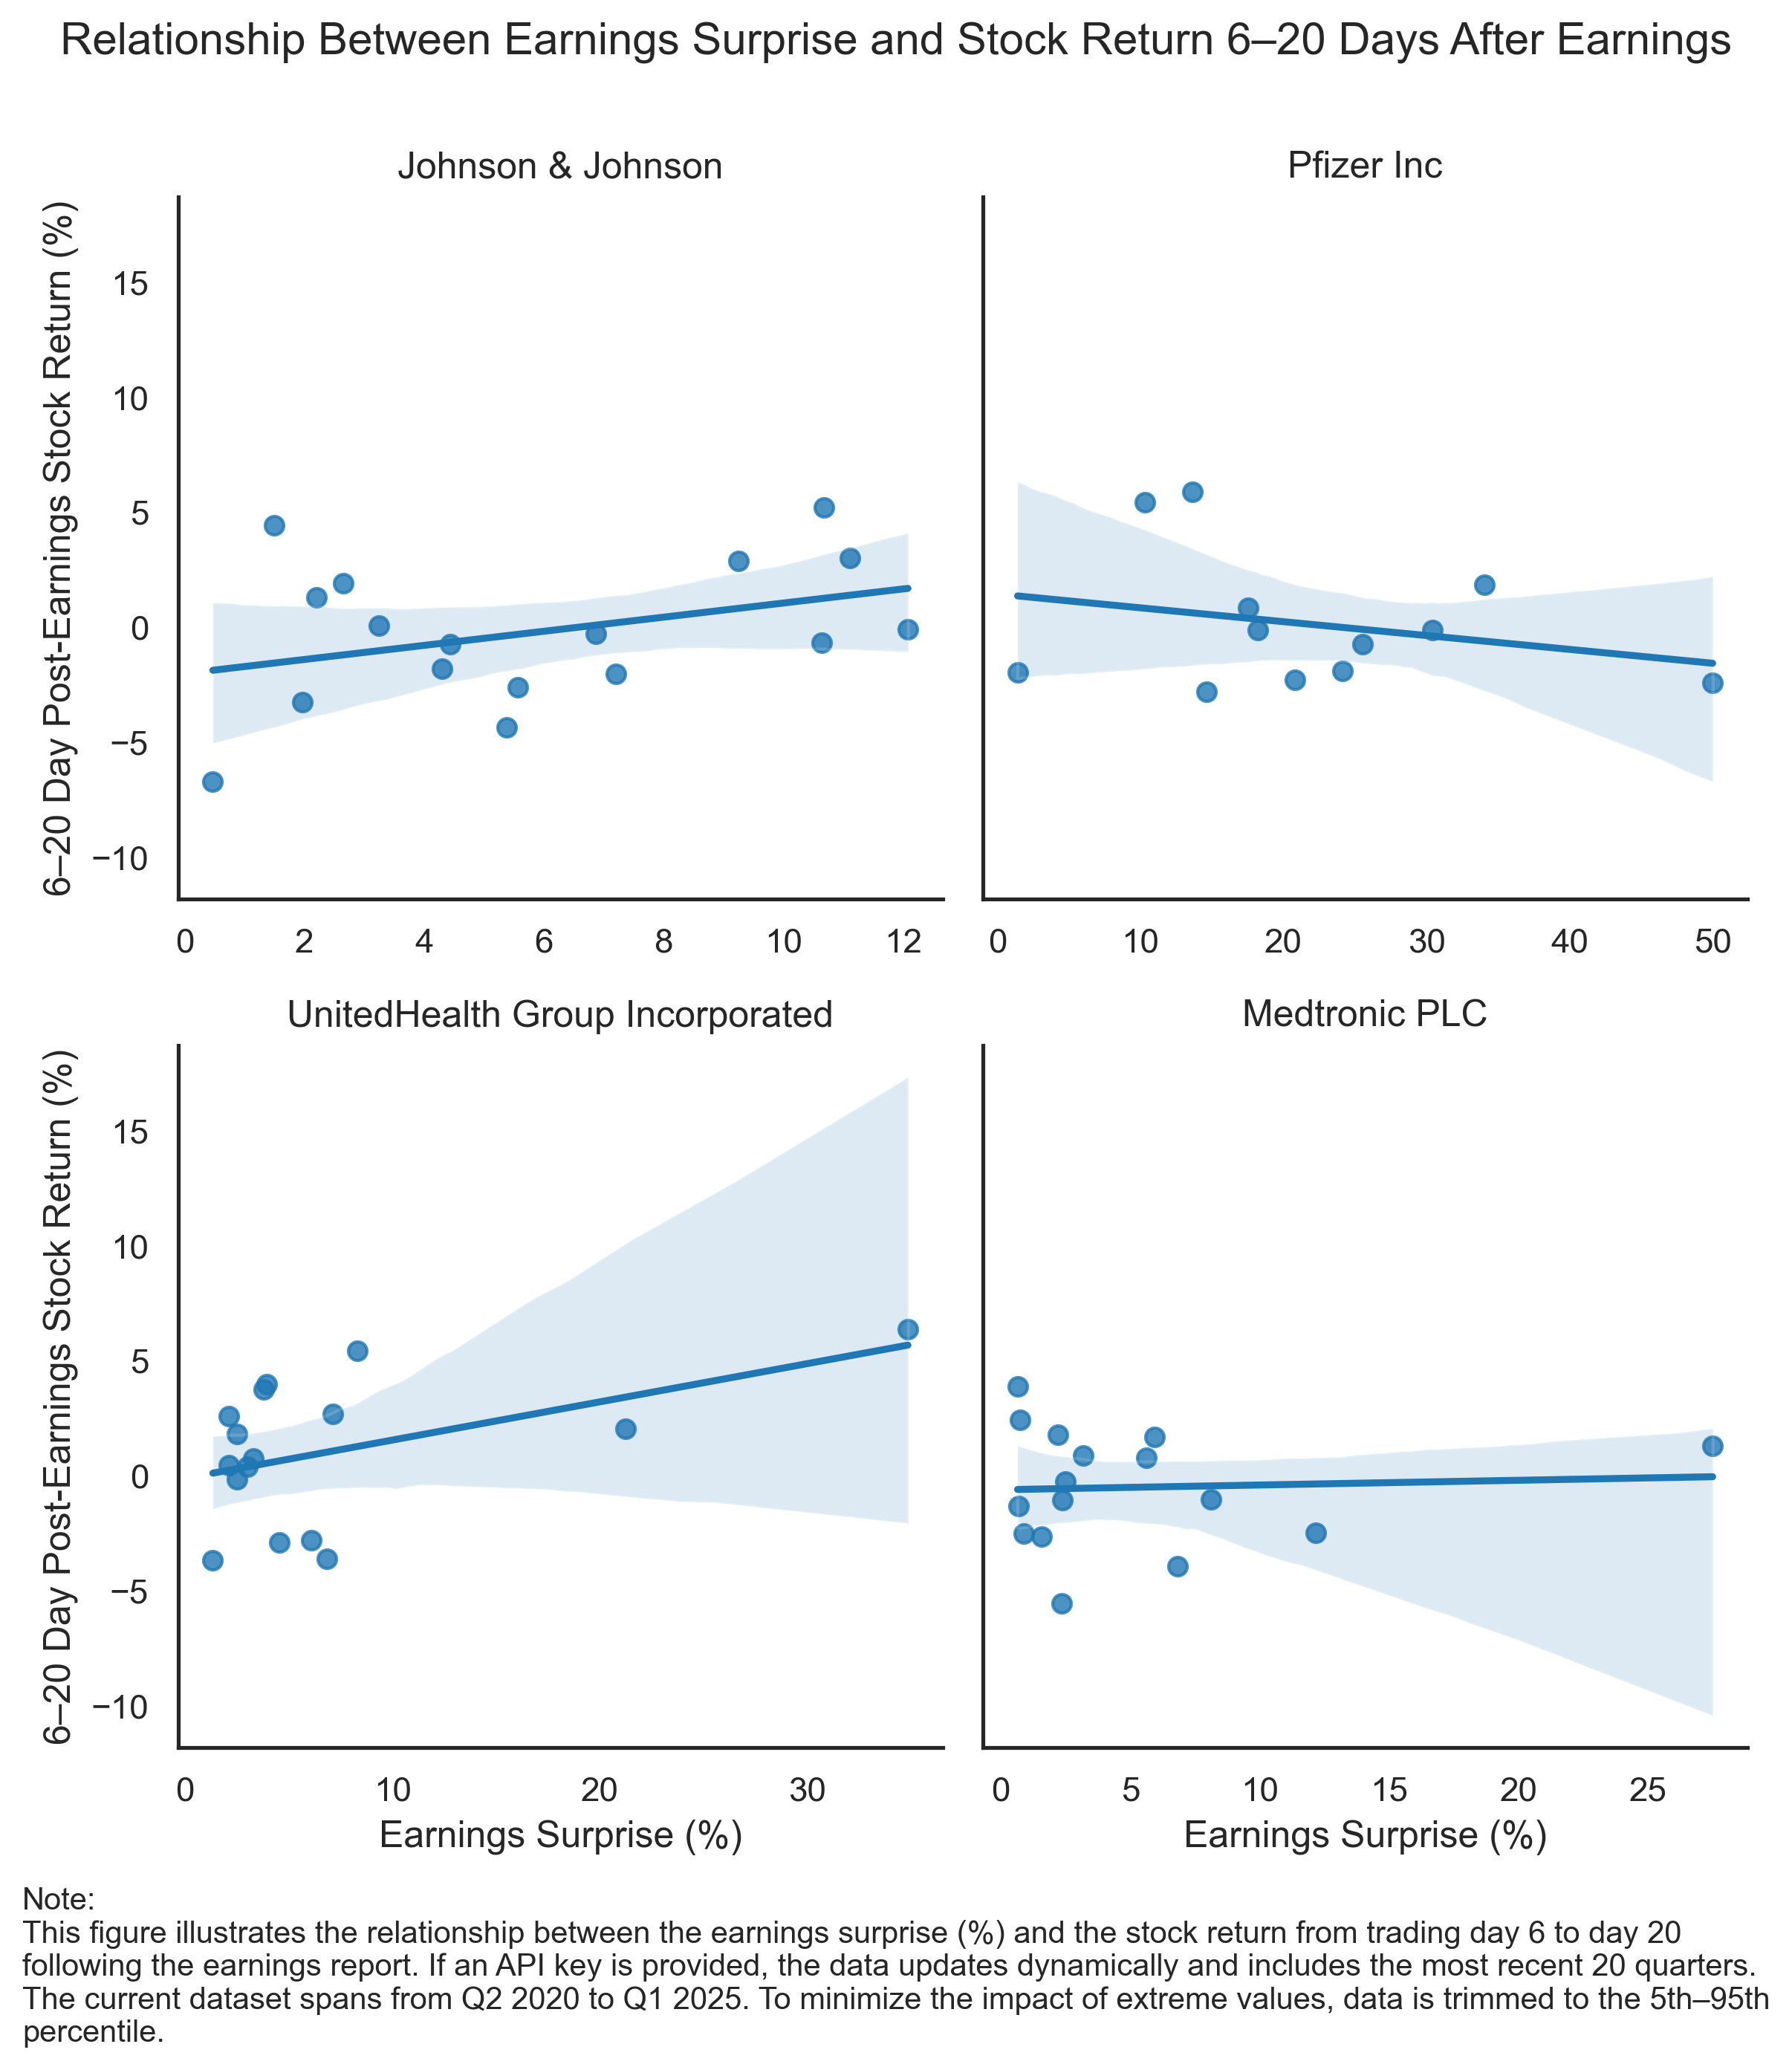


Running visualize_profitability_ratios_annual.py...
Script finished!


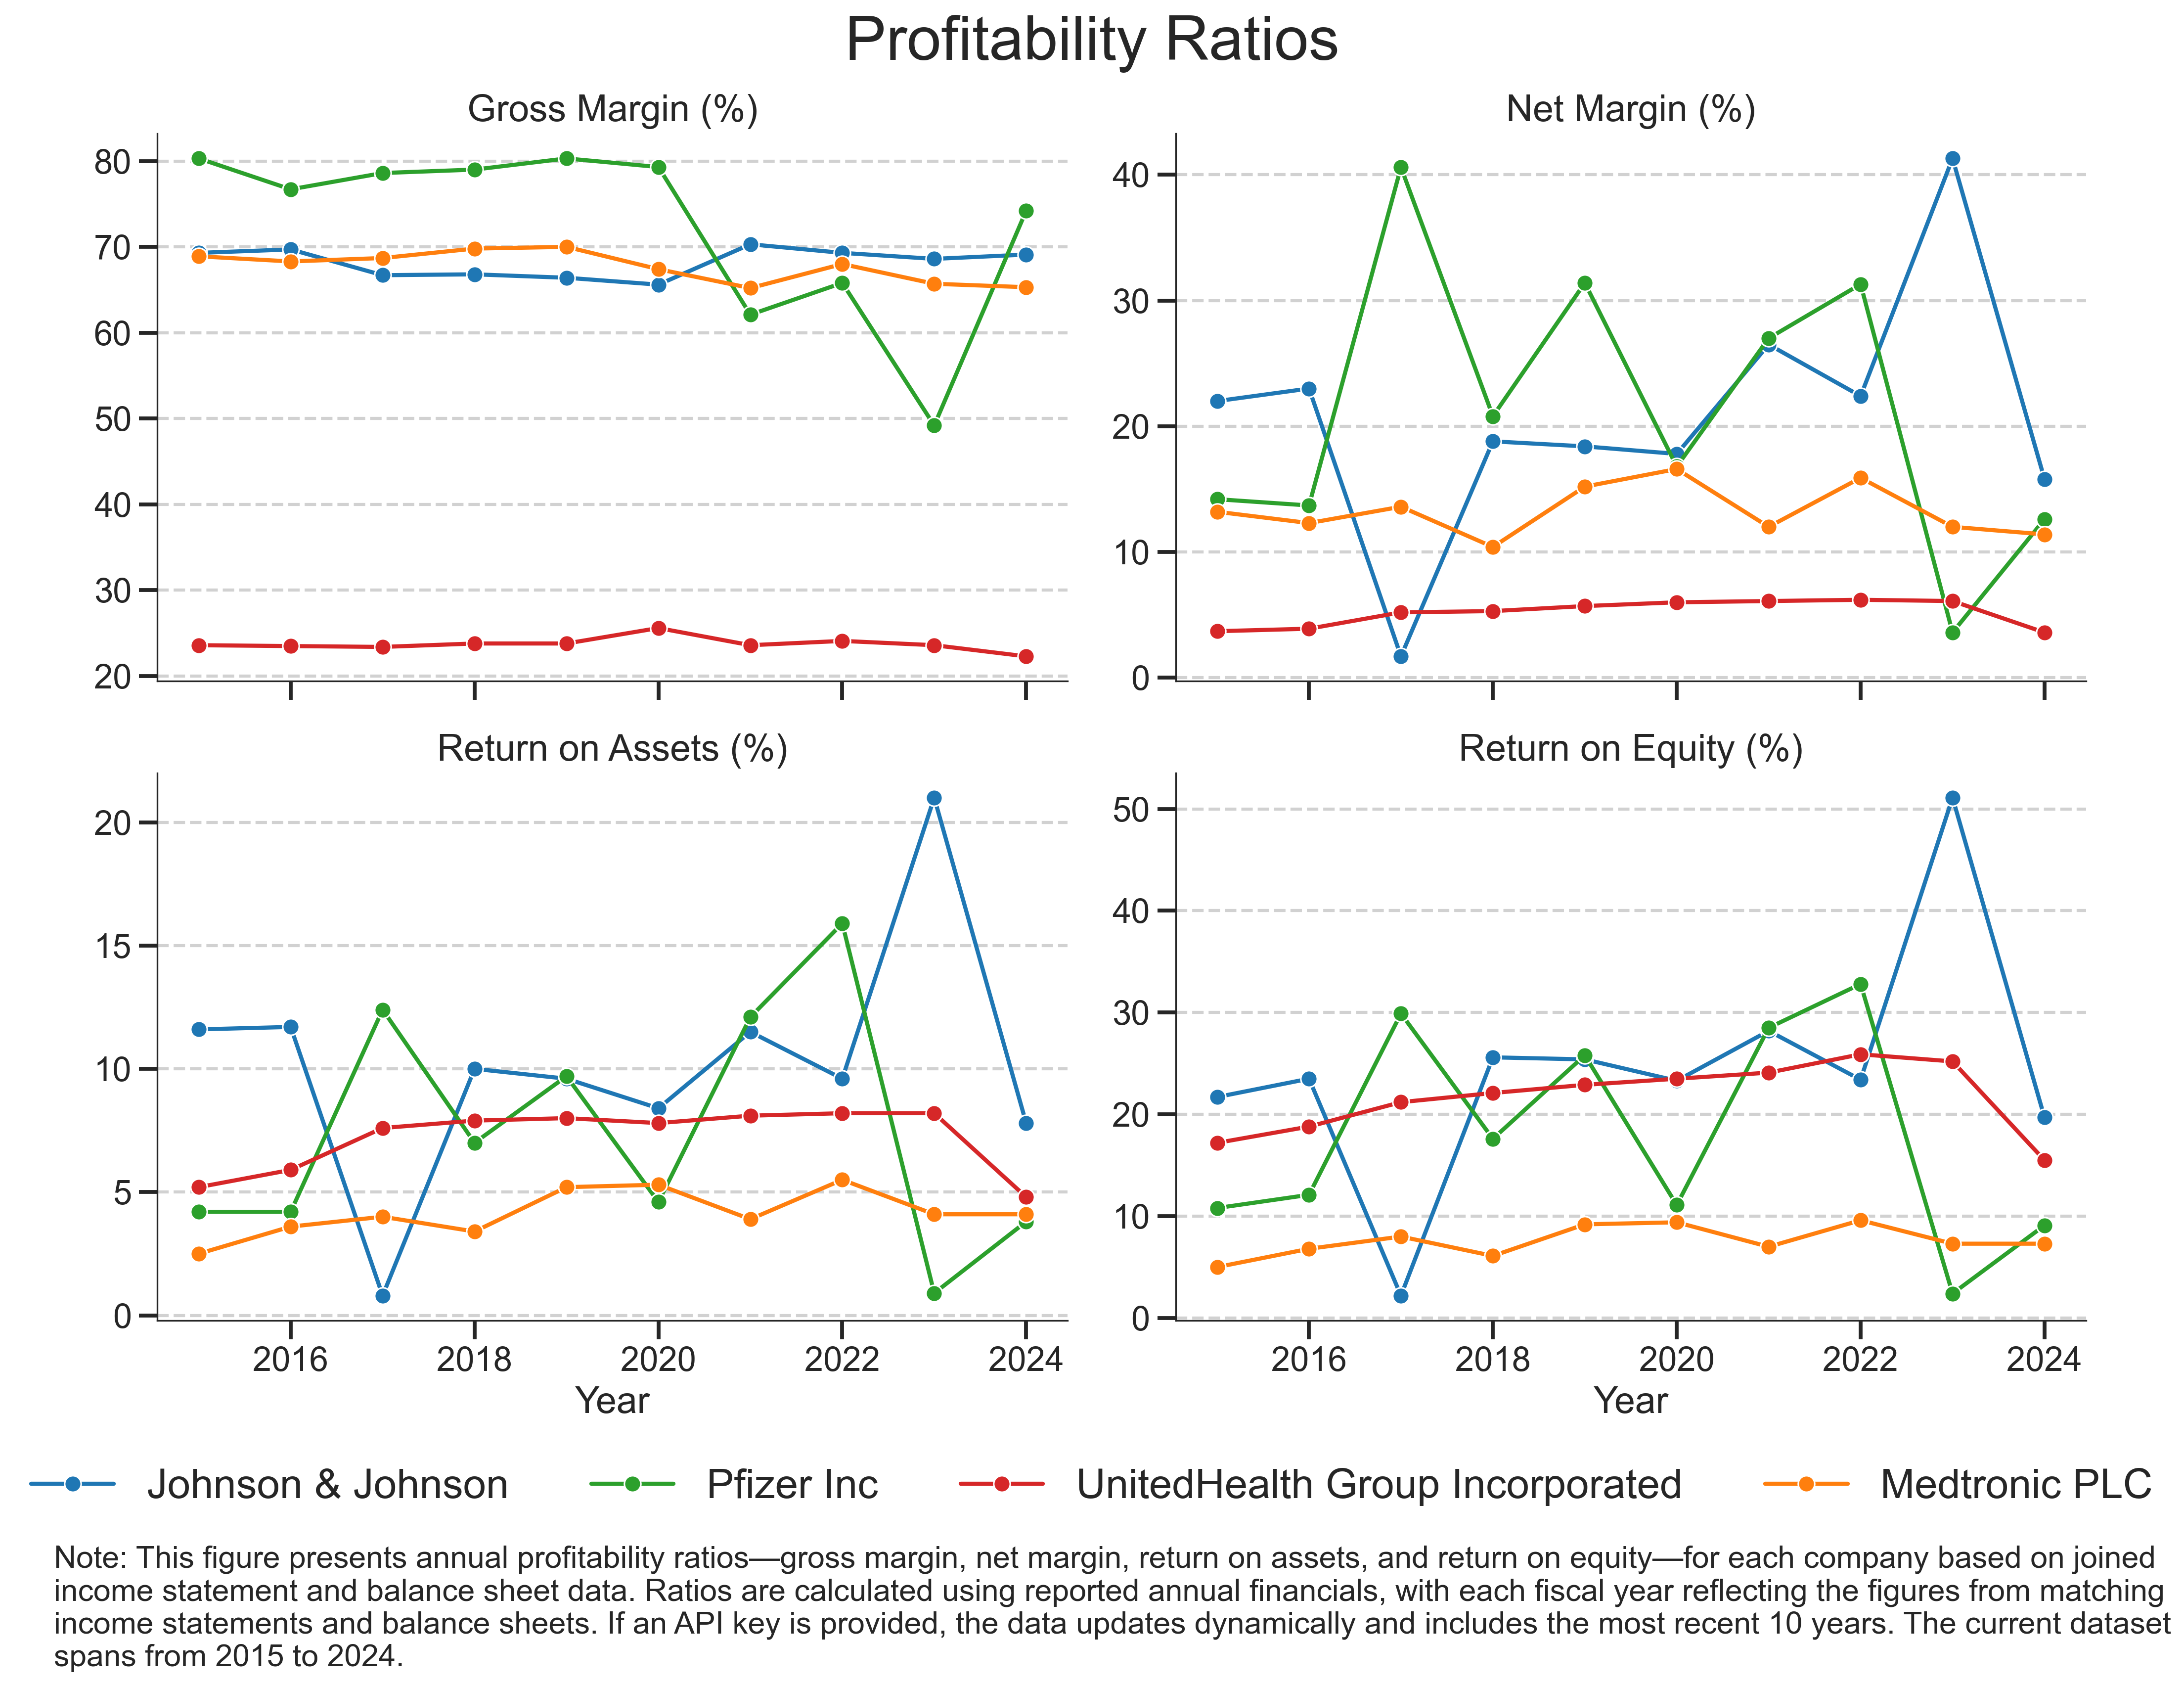


Running visualize_stock_volatility_last_6_months.py...
Script finished!


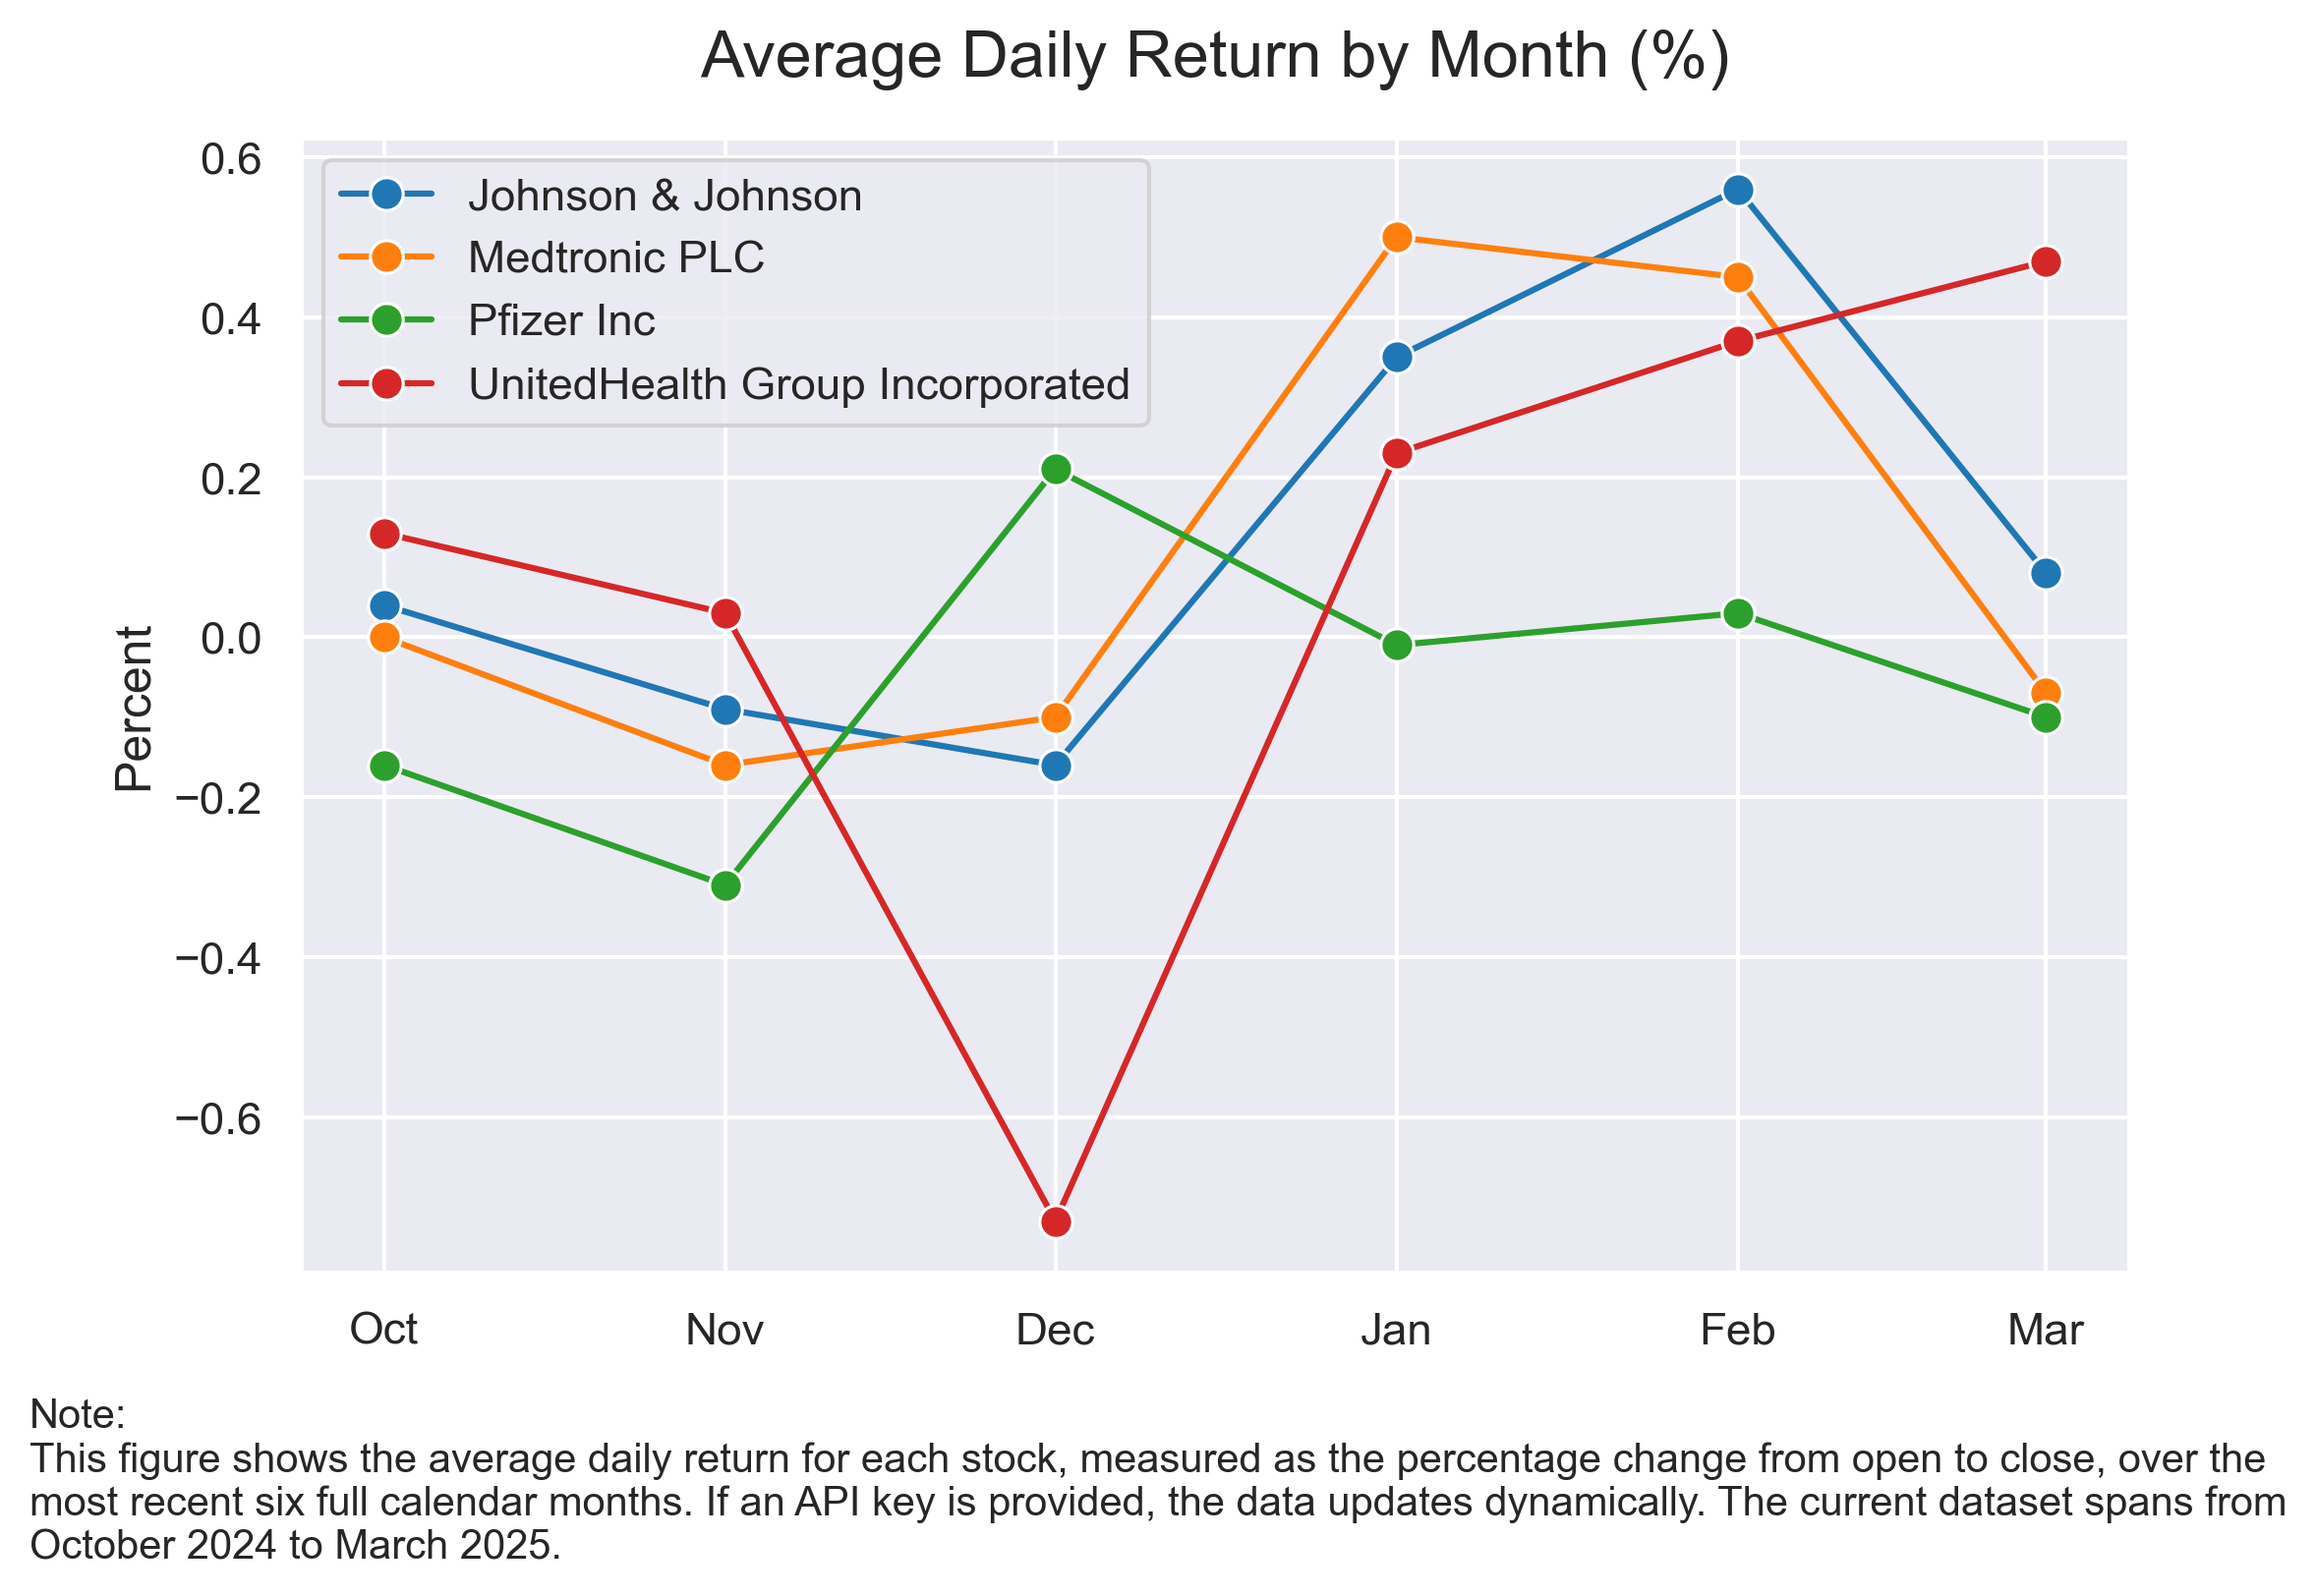


Running visualize_valuation_multiples.py...
Script finished!


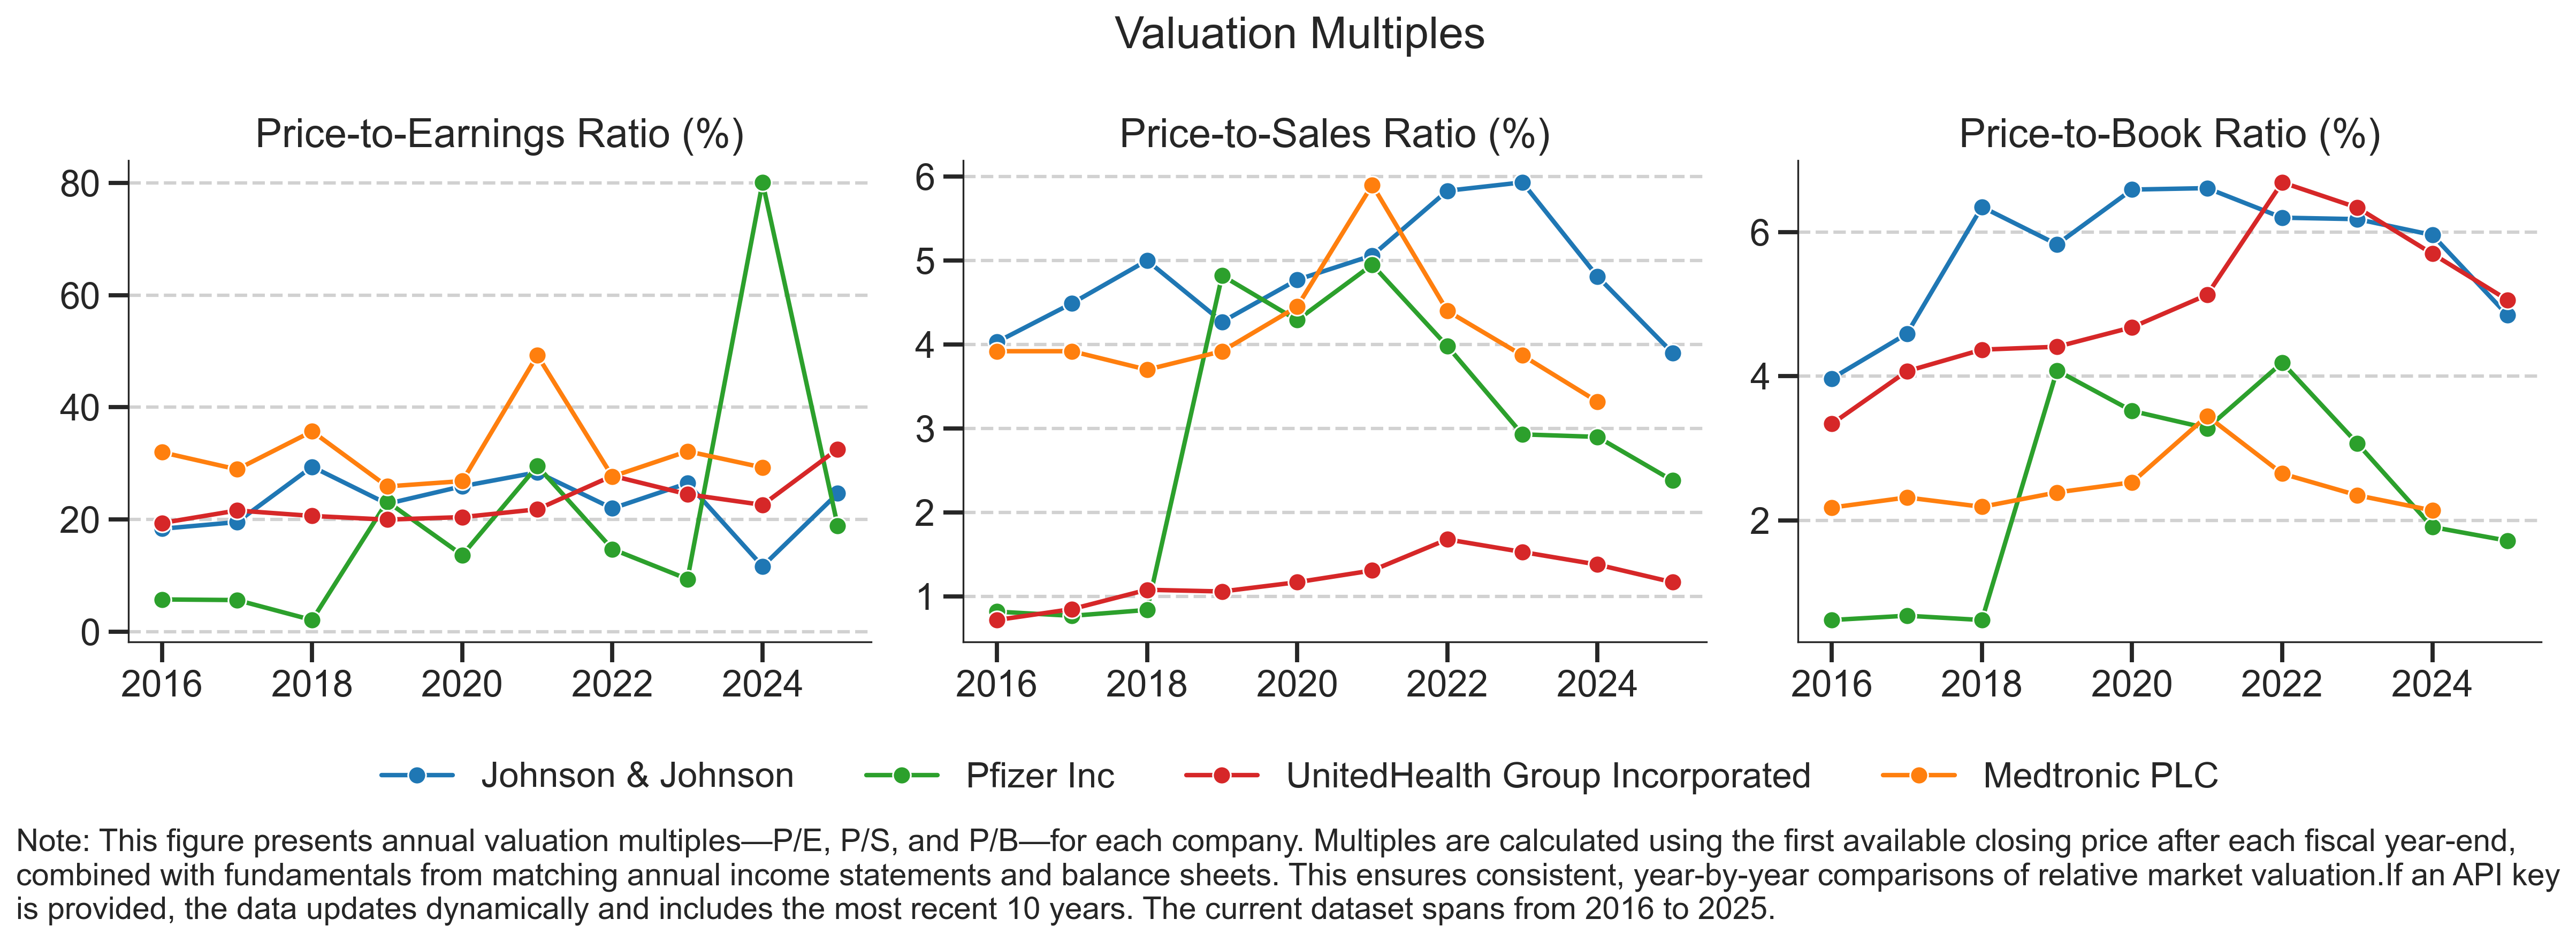

In [8]:
SCRIPTS_DIR = BASE_DIR / "scripts"
FIGURES_DIR = BASE_DIR / "figures"

# Scripts to run
script_files = [
    "visualize_earnings_surprise_vs_price.py",
    "visualize_monthly_net_2pct_gain_counts.py",
    "visualize_post_earnings_drift.py",
    "visualize_profitability_ratios_annual.py",
    "visualize_stock_volatility_last_6_months.py",
    "visualize_valuation_multiples.py"
]

for script_file in script_files:
    script_path = SCRIPTS_DIR / script_file
    print(f"\nRunning {script_file}...")
    
    try:
        subprocess.run(["python", str(script_path)], check=True)
        print("Script finished!")

        # Get figure filename
        figure_name = script_file.replace("visualize_", "").replace(".py", ".png")
        figure_path = FIGURES_DIR / figure_name

        # Display figure if it exists
        if figure_path.exists():
            display(Image(filename=str(figure_path)))
        else:
            print(f"Expected figure not found: {figure_path}")

    except subprocess.CalledProcessError as e:
        print(f"✗ Script {script_file} failed with error code: {e.returncode}")